# Deep Learning Project completed by Mone Madalina Ionela 
Matricola n. 00001041683


September 2024

# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.saving import register_keras_serializable

import matplotlib.pyplot as plt

#import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

Le us inspect and visualize data.

In [2]:
x_train_n = np.load('/kaggle/input/sst-dataset/x_train_night.npy')
x_val_n = np.load('/kaggle/input/sst-dataset/x_val_night.npy')
x_test_n = np.load('/kaggle/input/sst-dataset/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

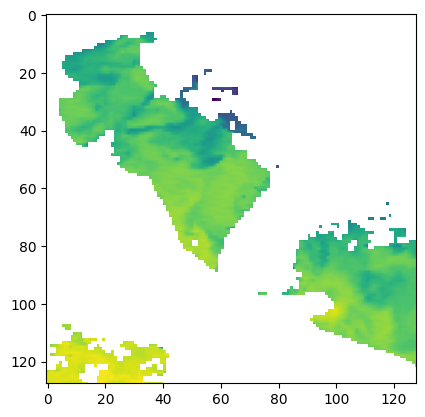

In [3]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [4]:
dates_train_n = np.load('/kaggle/input/sst-dataset/dates_train_night.npy')
dates_val_n = np.load('/kaggle/input/sst-dataset/dates_val_night.npy')
dates_test_n = np.load('/kaggle/input/sst-dataset/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


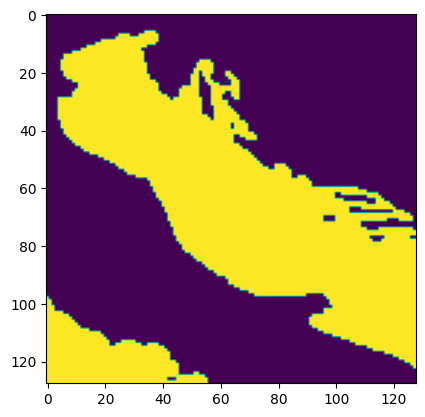

In [5]:
land_sea_mask = np.load('/kaggle/input/sst-dataset/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [6]:
baseline = np.load('/kaggle/input/sst-dataset/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


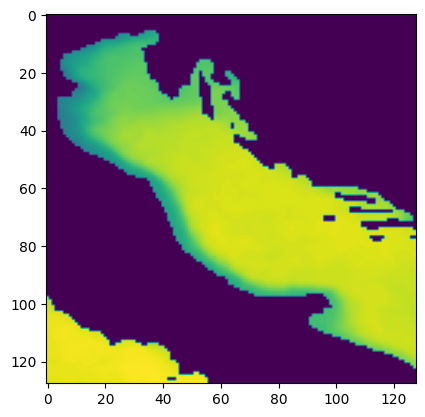

In [7]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [8]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [9]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [10]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [11]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [12]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 26.149999656153682
image 0; 0.0, 26.149999656153682
image 1; 0.0, 25.19999899902689
image 2; 0.0, 25.526964054353737


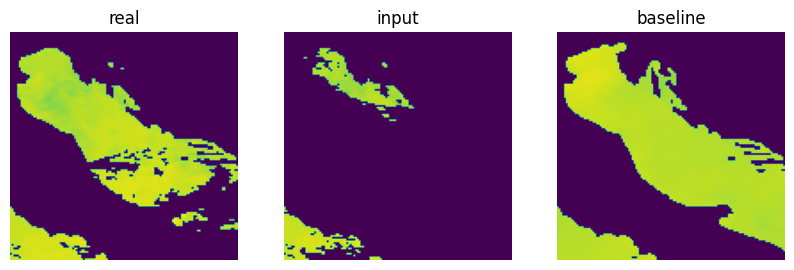

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


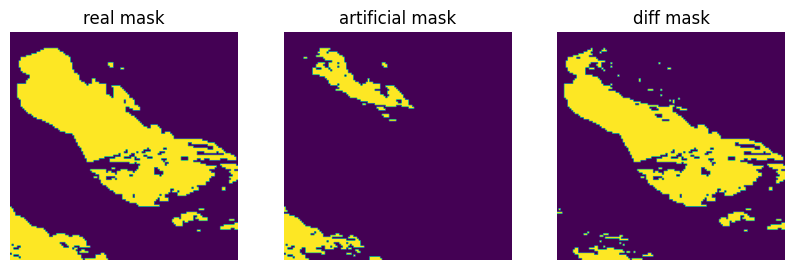

In [13]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [14]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.6228100339432594
RMSE std : 0.1799933638898448


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# My implementation

To address the proposed problem, I first attempted an approach by implementing a DCGAN. However, this did not yield good results in terms of RMSE & RMSE std, despite trying various loss functions. Initially, I used a MinMax Loss as described in the 2014 paper 'Generative Adversarial Networks' by Ian Goodfellow, and later experimented with custom loss functions, such as a perceptual loss. Even after 500 epochs of training, the results did not improve beyond those shown in the following image:

![Training ](epochss.png)
![Evaluation](dcgan_rmse.png)

So, I changed my approach and implemented a U-Net.

This function defines a U-Net convolutional neural network model using TensorFlow and Keras.
The U-Net network consists of an encoder and a decoder, with a bottleneck in the middle.
The encoder progressively reduces the spatial dimension of the input while increasing the number of filters, while the decoder performs the inverse operation, restoring the original spatial dimension.
The network uses L2 Regularization, Batch Normalization, and Spatial Dropout to improve generalization.
The network accepts a 4-channel input and returns a 3-channel output.

I experimented with using Conv2DTranspose, adjusting dropout rates, the regularization coefficient, and kernel size, but the configuration below yielded the best results

In [2]:
def make_unet():
    inputs = tf.keras.Input(shape=(128, 128, 4))
    
    # L2 Regularizer
    regularizer = regularizers.l2(1e-4)

    # Encoder
    c1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.SpatialDropout2D(0.3)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.SpatialDropout2D(0.3)(c2) 
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.SpatialDropout2D(0.3)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.SpatialDropout2D(0.3)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck 
    c5 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same', dilation_rate=1, kernel_regularizer=regularizer)(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(2048, (3, 3), activation='relu', padding='same', dilation_rate=1, kernel_regularizer=regularizer)(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.SpatialDropout2D(0.3)(c5)  
    
    # Decoder (upsampling)
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.Concatenate()([u6, c4])
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.SpatialDropout2D(0.3)(c6) 

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.SpatialDropout2D(0.3)(c7) 

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.SpatialDropout2D(0.3)(c8) 

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer)(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.SpatialDropout2D(0.3)(c9) 
    
    # Output layer: 3 chanels output
    outputs = layers.Conv2D(3, (1, 1), activation='linear')(c9) #linear activation for image reconstruction

    model = Model(inputs, outputs)
    return model

In [3]:
model = make_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,736 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (SpatialDropout2D)  │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_1[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_5[0][0]  

 Total params: 125,548,931 (478.93 MB)

 Trainable params: 125,525,379 (478.84 MB)

 Non-trainable params: 23,552 (92.00 KB)

This function defines a custom loss function for a Keras model.
The loss is calculated based on the difference between the predicted and true images, weighted by an artificial mask (diff_mask) provided in the true labels. The loss is computed for each channel in the predicted output and then averaged.

In [17]:
@register_keras_serializable() #for saving the best model
def loss_fn(y_true, y_pred):
    
    # Extract artificial mask and real image from the true labels
    artificial_mask_current = y_true[..., 2]  # diff_mask
    image_current = y_true[..., 0]  # real image
    
    # Calculate the loss for each channel in y_pred 
    losses = []
    for i in range(y_pred.shape[-1]):
        diff = y_pred[..., i] - image_current
        masked_diff = diff * artificial_mask_current
        # Calculate the mean squared error, considering only the masked regions
        mse = tf.reduce_sum(tf.square(masked_diff)) / tf.reduce_sum(artificial_mask_current)
        losses.append(mse)
    
    # Take the mean of the losses across all channels
    total_loss = tf.reduce_mean(losses)
    
    return total_loss

I attempted to implement a new version of the loss function that also incorporates the land-sea mask, but it didn't lead to significant improvement, so I reverted to the previous one

In [23]:
def loss_fn_landsea(y_true, y_pred):
    artificial_mask_current = y_true[..., 2]  # diff_mask
    image_current = y_true[..., 0]  # real image
    land_sea_mask = y_true[..., 2]  # land-sea mask
    
    losses = []
    for i in range(y_pred.shape[-1]):
        diff = y_pred[..., i] - image_current
        masked_diff = diff * artificial_mask_current * land_sea_mask
        mse = tf.reduce_sum(tf.square(masked_diff)) / tf.reduce_sum(artificial_mask_current * land_sea_mask)
        losses.append(mse)
    
    total_loss = tf.reduce_mean(losses)
    
    return total_loss

The following functions define custom metrics for the training phase, registered for use in Keras models.

The metrics include MSE (Mean Squared Error), MAE (Mean Absolute Error), and RMSE (Root Mean Squared Error), which are commonly used to evaluate the model's performance.

In [18]:
@register_keras_serializable()
def mse(y_true, y_pred):
    return tf.keras.losses.MeanSquaredError()(y_true, y_pred)

@register_keras_serializable()
def mae(y_true, y_pred):
    return tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)

@register_keras_serializable()
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

These callback functions are added to enhance the training process by improving performance and preventing overfitting.
- ReduceLROnPlateau reduces the learning rate when validation loss stagnates, helping the model converge.
- EarlyStopping tracks validation loss and stops training when no further improvement is observed, restoring the best model weights. A patience of 7 is set to allow ReduceLROnPlateau enough time to take effect.
- ModelCheckpoint saves the model with the best validation loss during training, ensuring that the best version is preserved.

In [ ]:
 # Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    start_from_epoch=0,
    patience=7,
    mode='min'
)

# Reduce learning rate callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", 
    patience=4,
    mode='min'
)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    'best_model.keras',  
    monitor='val_loss',  
    save_best_only=True
)

callbacks = [reduce_lr, early_stopping, model_checkpoint]

The model is compiled with the loss function mentioned before.

The Adam optimizer is used with a learning rate of 1e-4 for efficient gradient-based optimization.

In addition to the custom loss function, the metrics MSE, MAE, and RMSE are included to evaluate the model's performance during training and validation.

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), 
              loss=loss_fn, 
              metrics=[mse, mae, rmse])

The model is trained for 50 epochs using the `train_generator` for training data and `val_generator` for validation data.

At the end a plot of training, a plot to visualize the performance during training


Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 149s 644ms/step - loss: 0.0560 - mae: 0.4863 - mse: 1.4502 - rmse: 1.1984 - val_loss: 0.0419 - val_mae: 0.4072 - val_mse: 0.5524 - val_rmse: 0.7401 - learning_rate: 1.0000e-04
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 108s 595ms/step - loss: 0.0587 - mae: 0.4954 - mse: 1.3042 - rmse: 1.1384 - val_loss: 0.0430 - val_mae: 0.4049 - val_mse: 0.6070 - val_rmse: 0.7773 - learning_rate: 1.0000e-04
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 115s 632ms/step - loss: 0.0529 - mae: 0.4867 - mse: 1.2857 - rmse: 1.1309 - val_loss: 0.0393 - val_mae: 0.3978 - val_mse: 0.4777 - val_rmse: 0.6888 - learning_rate: 1.0000e-04
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 116s 637ms/step - loss: 0.0486 - mae: 0.4822 - mse: 1.3111 - rmse: 1.1403 - val_loss: 0.0352 - val_mae: 0.4001 - val_mse: 0.5377 - val_rmse: 0.7306 - learning_rate: 1.0000e-04
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 108s 596ms/step - loss: 0.0468 - mae: 0.4731 - mse: 1.2398 - rmse: 1.1097 - val_loss: 0.0376 - v

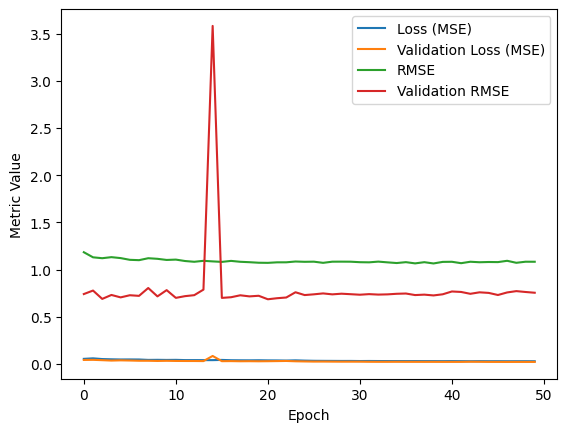

In [20]:
# Generate input with the function provided
train_generator = generator(batch_size=32, dataset=x_train_n, dates=dates_train_n)
val_generator = generator(batch_size=32, dataset=x_val_n, dates=dates_val_n)

# Training del modello
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(x_train_n)//32, 
                    validation_steps=len(x_val_n)//32, 
                    epochs=50,
                    callbacks=callbacks
                        )

plt.plot(history.history['loss'], label='Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.plot(history.history['rmse'], label='RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

## Evaluation 
using the function provided. 

#### Load the best model saved and visualize the performance

In [25]:
best_model = load_model("best_model.keras")

In [26]:
def calculate_rmse_values(test_gen, best_model, x_train_std, x_train_mean):
    RMSE_values = {}

    for round_num in range(1, 11):
        RMSE = []
        tot = 50

        for _ in range(tot):
            # Generate a batch
            batch_x, batch_y = next(test_gen)
            
            predictions = best_model.predict(batch_x, verbose=0)

            # Denormalize data
            predictions_denorm = predictions * x_train_std + x_train_mean
            true_values_denorm = batch_y[..., 0] * x_train_std + x_train_mean
            
            # Transform the shape of predictions to match true_values_denorm
            predictions_denorm = np.mean(predictions_denorm, axis=-1)

            # Get the masks and calculate the errors
            diffMask = batch_y[..., 2]
            diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
            squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))
            RMSE.append(np.sqrt(squared_errors))

        RMSE = np.concatenate(RMSE)

        RMSE_values[f'round{round_num}'] = {
            'RMSE': np.mean(RMSE),
            'RMSE_std': np.std(RMSE),
            'RMSE_values': RMSE
        }

    return RMSE_values

In [28]:
def print_rmse_summary(RMSE_values):
    for round_key, values in RMSE_values.items():
        print(f"{round_key}: RMSE = {values['RMSE']}, RMSE_std = {values['RMSE_std']}")

In [32]:
RMSE_values = calculate_rmse_values(test_gen, best_model, x_train_std, x_train_mean)

### Printing the optained RMSE & RMSE std values for 10 rounds of evaluation function 

In [30]:
print_rmse_summary(RMSE_values)

round1: RMSE = 0.5094884645581199, RMSE_std = 0.14836397331011297
round2: RMSE = 0.5013398686288029, RMSE_std = 0.14733008693313368
round3: RMSE = 0.5077700700800759, RMSE_std = 0.1491579416881979
round4: RMSE = 0.5043730630722303, RMSE_std = 0.15456626469695844
round5: RMSE = 0.5150662724703945, RMSE_std = 0.15965699014647866
round6: RMSE = 0.4984357335638595, RMSE_std = 0.13958434693652683
round7: RMSE = 0.5070139100660179, RMSE_std = 0.15047031273169506
round8: RMSE = 0.5086824132542085, RMSE_std = 0.1570831889725852
round9: RMSE = 0.506679535607773, RMSE_std = 0.15102933590656462
round10: RMSE = 0.5031826523735805, RMSE_std = 0.14852100038900512


### Best RMSE obtained: 0,49

### Best RMSE std obtained: 0,13

In [34]:
export_model_path = 'outputs/best_model.h5'
model.save(export_model_path)
print("model saved")

model saved


#### Visualize the prediction made

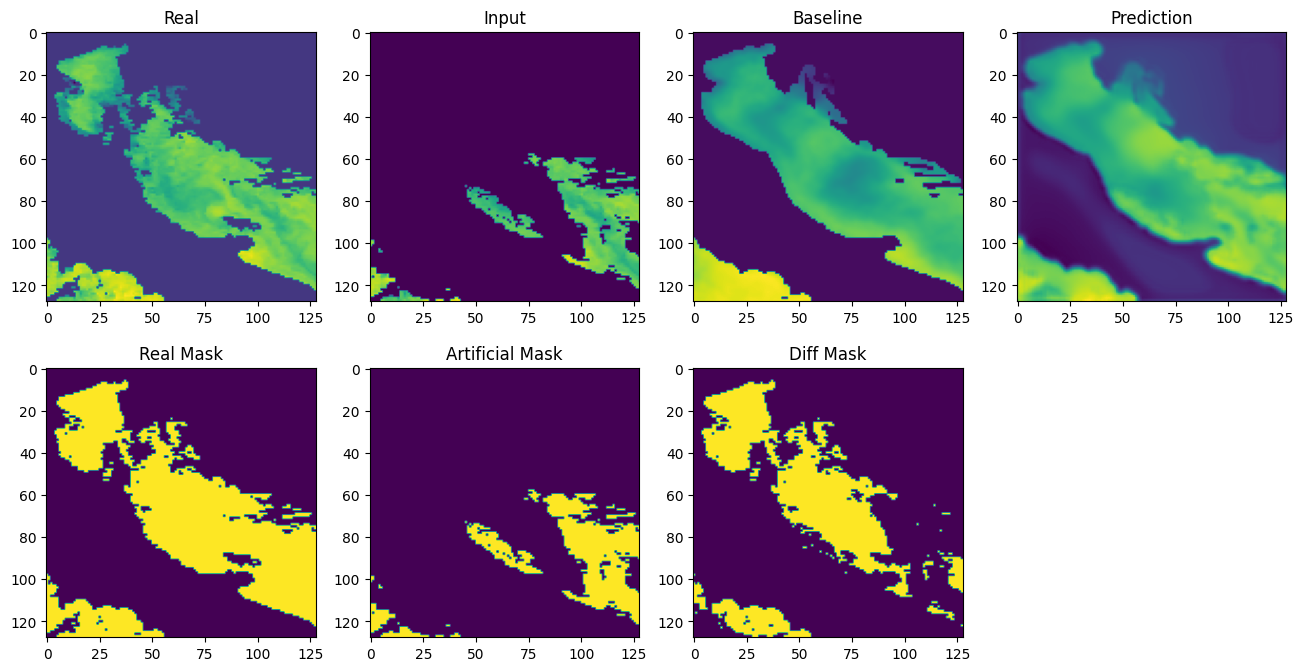

In [38]:
# Get the masks
real_mask = batch_y[..., 1]   # Real mask
artificial_mask = batch_x[..., 1]  # Artificial mask used in the input
diff_mask = batch_y[..., 2]   # Difference mask, where the performance is evaluated

def plot_sst_reconstruction(true_img, input_img, baseline_img, pred_img, real_mask, artificial_mask, diff_mask):
    fig, axs = plt.subplots(2, 4, figsize=(16, 8))

    # First row - Real, Input, Baseline, Prediction
    axs[0, 0].imshow(true_img, cmap='viridis')
    axs[0, 0].set_title("Real")

    axs[0, 1].imshow(input_img, cmap='viridis')
    axs[0, 1].set_title("Input")

    axs[0, 2].imshow(baseline_img, cmap='viridis')
    axs[0, 2].set_title("Baseline")

    axs[0, 3].imshow(pred_img, cmap='viridis')
    axs[0, 3].set_title("Prediction")

    # Second row - Real Mask, Artificial Mask, Diff Mask
    axs[1, 0].imshow(real_mask, cmap='viridis')
    axs[1, 0].set_title("Real Mask")

    axs[1, 1].imshow(artificial_mask, cmap='viridis')
    axs[1, 1].set_title("Artificial Mask")

    axs[1, 2].imshow(diff_mask, cmap='viridis')
    axs[1, 2].set_title("Diff Mask")

    fig.delaxes(axs[1, 3])

    plt.show()

plot_sst_reconstruction(true_values_denorm[0], batch_x[0, ..., 0], batch_x[0, ..., 3], predictions_denorm[0], real_mask[0], artificial_mask[0], diff_mask[0])


As we can see from the plot, the prediction is blurred compared to the other images, indicating that the model may still need improvement.